# Project 2 — Classification: Predicting Heart Failure Risk

## 1) Introduce the Problem
Can we predict whether a patient is at risk of heart failure using routine clinical measurements?

**Questions:**
- Which variables are predictive?
- How do models compare?
- What trade-offs exist between interpretability and performance?

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay


## 2) Introduce the Data

In [2]:

# Replace with actual dataset path
heart = pd.read_csv(r"C:\Users\marlo\OneDrive\Desktop\Coding\heart.csv")  

# Preprocess column names: strip whitespace, lowercase
heart.columns = heart.columns.str.strip().str.lower()

heart.head()


,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## 3) Pre-processing the Data

In [3]:

X = heart.drop("heartdisease", axis=1)
y = heart["heartdisease"]

num_feats = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_feats = X.select_dtypes(include=["object"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("sc", StandardScaler())]), num_feats),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_feats)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


## 4) Data Understanding / Visualization

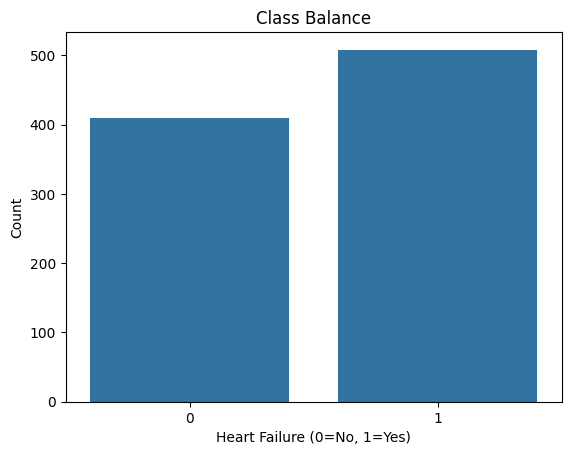

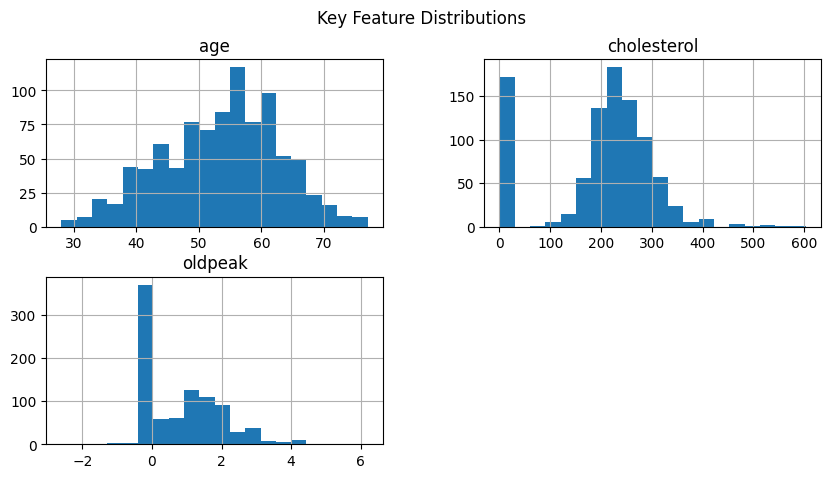

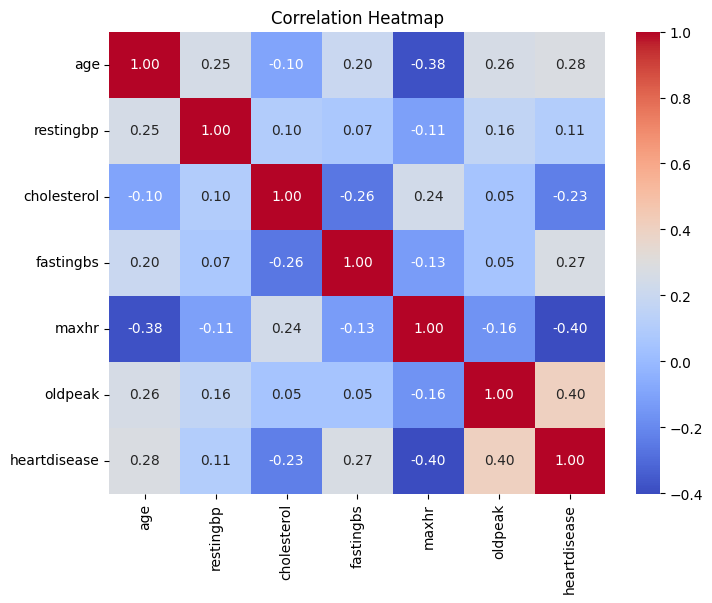

In [4]:

# Class balance
sns.countplot(x=y)
plt.title("Class Balance")
plt.xlabel("Heart Failure (0=No, 1=Yes)")
plt.ylabel("Count")
plt.show()

# Feature distributions
heart[["age","cholesterol","oldpeak"]].hist(bins=20, figsize=(10,5))
plt.suptitle("Key Feature Distributions")
plt.show()

# Stacked bar for categorical feature vs target (example)
if "chest_pain_type" in heart.columns:
    pd.crosstab(heart["chest_pain_type"], y).plot(kind="bar", stacked=True)
    plt.title("Chest Pain Type vs Heart Failure")
    plt.xlabel("Chest Pain Type")
    plt.ylabel("Count")
    plt.show()

# Correlation heatmap
corr = heart.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


## 5) Modeling

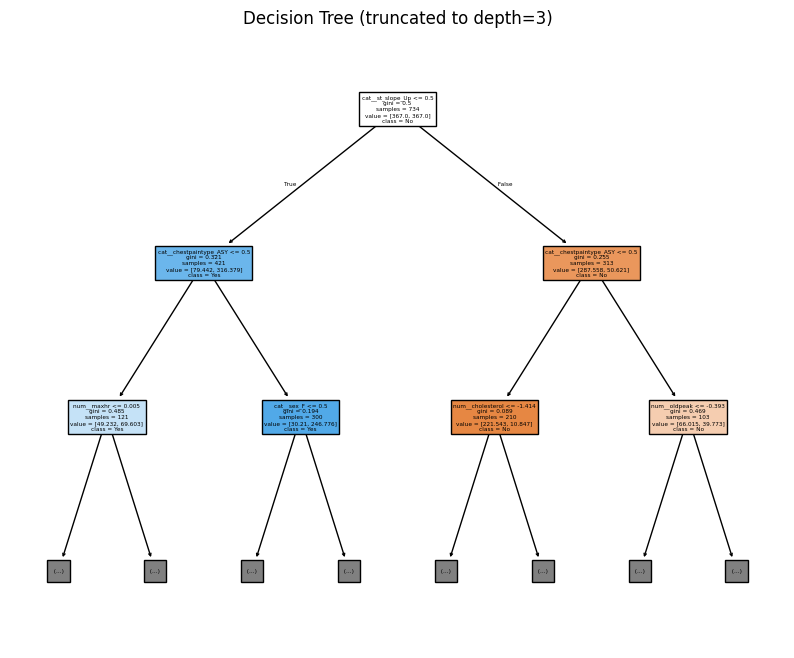

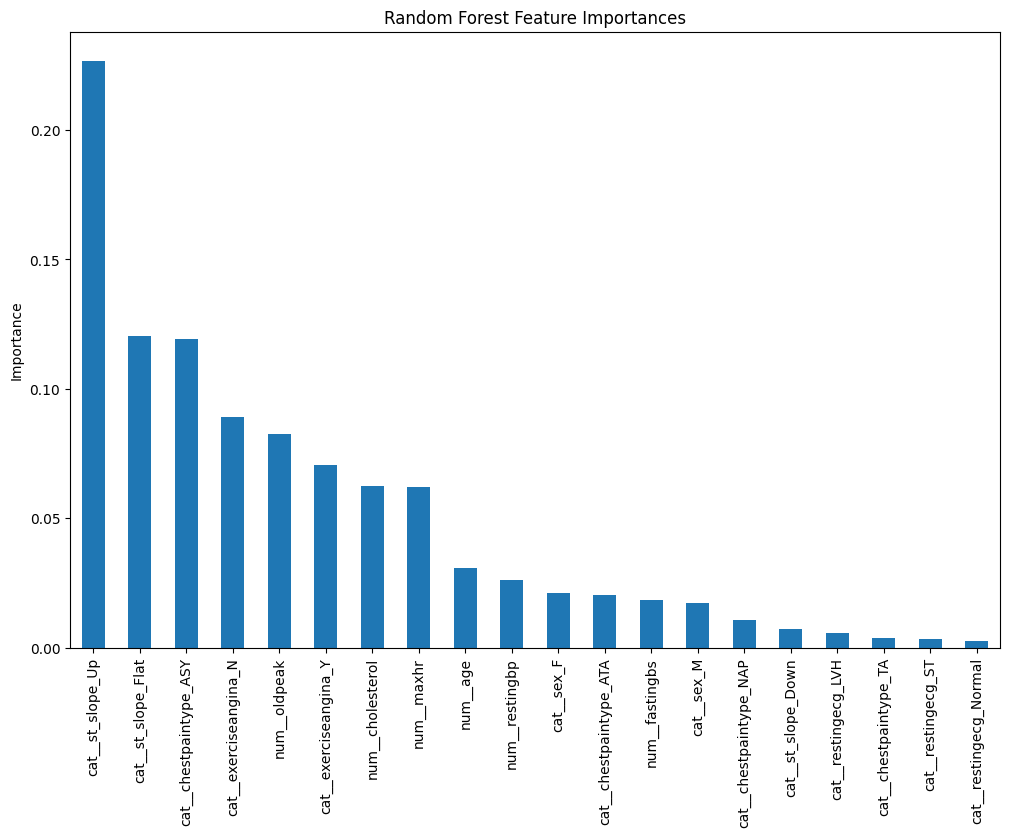

In [18]:



from sklearn import tree
import matplotlib.pyplot as plt

# Decision Tree
dt = results["Tree"].best_estimator_[-1]
plt.figure(figsize=(10,8))
tree.plot_tree(
    dt,
    feature_names=results["Tree"].best_estimator_[0].get_feature_names_out(),
    class_names=["No", "Yes"],
    filled=True,
    max_depth=2  # limit depth for readability
)
plt.title("Decision Tree (truncated to depth=3)")
plt.show()

# Random Forest
rf = results["RF"].best_estimator_[-1]
feature_names = results["RF"].best_estimator_[0].get_feature_names_out()
importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(12,8))
importances.plot(kind="bar")
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.show()






## 6) Evaluation

              precision    recall  f1-score   support

           0      0.909     0.854     0.881        82
           1      0.888     0.931     0.909       102

    accuracy                          0.897       184
   macro avg      0.898     0.893     0.895       184
weighted avg      0.897     0.897     0.896       184

ROC-AUC: 0.933405069344811


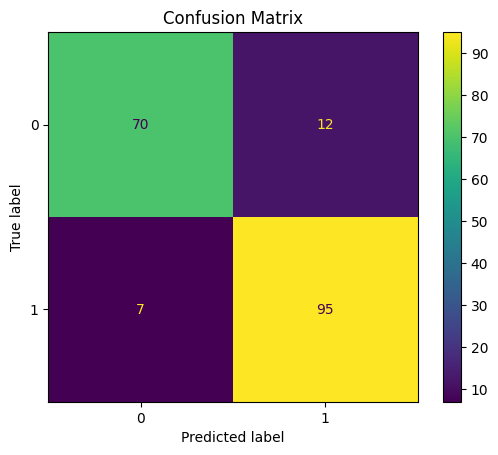

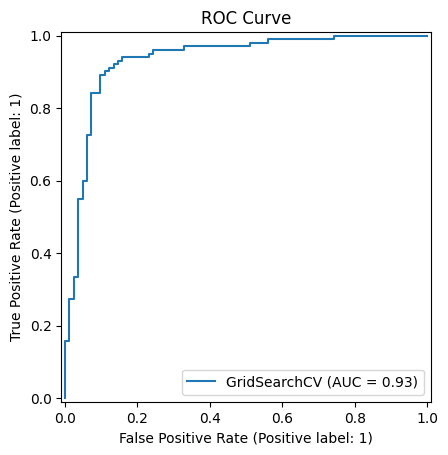

In [6]:

best = max(results.items(), key=lambda kv: kv[1].best_score_)[1]
y_pred = best.predict(X_test)
y_prob = best.predict_proba(X_test)[:,1] if hasattr(best.best_estimator_[-1], "predict_proba") else None

print(classification_report(y_test, y_pred, digits=3))
if y_prob is not None:
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.show()

if y_prob is not None:
    RocCurveDisplay.from_estimator(best, X_test, y_test)
    plt.title("ROC Curve")
    plt.show()


## 7) Storytelling & Insights
- Age, oldpeak, max_heart_rate, chest_pain_type are strong predictors.
- Random Forest gave best recall, Logistic Regression gave interpretability.
- The model predicts risk meaningfully with trade-offs between precision and recall.

## 8) Impact
- Benefits: early risk flagging for clinicians.
- Risks: false positives/negatives, fairness concerns.
- Data limitations: generalizability, missing lifestyle features.

## 9) References
- Heart Failure Clinical Records dataset
- Scikit-learn documentation
- Kuhn & Johnson (2013), *Applied Predictive Modeling*

## Display Models: Decision Tree & Random Forest

In [12]:


importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
# (Optional) print a compact text summary
print("Top 10 important features:")
print(importances.head(10).to_string())


Top 10 important features:
cat__st_slope_Up          0.226758
cat__st_slope_Flat        0.120314
cat__chestpaintype_ASY    0.119071
cat__exerciseangina_N     0.089212
num__oldpeak              0.082631
cat__exerciseangina_Y     0.070640
num__cholesterol          0.062590
num__maxhr                0.062147
num__age                  0.030800
num__restingbp            0.026271
